# STACKING 1 - Linear, FM, afm, CrossNet, CIN, DeepFM

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
# ---------------------------------
from tools import CV, Tuning, CVGetScore
from hyperopt import hp

In [2]:
y_train = pd.read_csv('../data/train.csv', index_col='id')['target'].values
print(y_train.shape)

(600000,)


In [3]:
def mk_mdf(mdict, rule_dict={}):
    df = list()
    for name, path in mdict.items():
        marr = np.load(path)
        df.append(pd.DataFrame(data=marr, columns=[f'{name}{i}' for i in range(marr.shape[1])]))
    df = pd.concat(df, axis=1)
    
    mdf = dict()
    for colname, rules in rule_dict.items():
        values = np.mean(df[rules].values, axis=1)
        mdf[colname] = values
    del df
    return pd.DataFrame(mdf)

In [4]:
train_dict = {
    'lr': '../tmp/lr/2432137157stacking1.npy',
    'fm': '../tmp/fm/3366580204stacking1.npy',
    'afm': '../tmp/afm/1372484291stacking1.npy',
    'cross': '../tmp/cross/2072349059stacking1.npy',
    'cin': '../tmp/cin/1960993645stacking1.npy',
    'deepfm': '../tmp/deepfm/1615107092stacking1.npy'
}


test_dict = {
    'lr': '../tmp/lr/2432137157predict.npy',
    'fm': '../tmp/fm/3366580204predict.npy',
    'afm': '../tmp/afm/1372484291predict.npy',
    'cross': '../tmp/cross/2072349059predict.npy',
    'cin': '../tmp/cin/1960993645predict.npy',
    'deepfm': '../tmp/deepfm/1615107092predict.npy'
}


rule_dict = {
    'deepfm': [f'deepfm{i}' for i in range(10)],
    'cin':  [f'cin{i}' for i in range(5)],
    'fm':  [f'fm{i}' for i in range(5)],
    'cross1': ['cross0', 'cross1', 'cross3', 'cross4'],
    'cross2': ['cross2'],
    'lr': ['lr0', 'lr1', 'lr2', 'lr4'],
    'lr2': ['lr3']
}

x_train = mk_mdf(train_dict, rule_dict).values
x_test = mk_mdf(test_dict, rule_dict).values

# SVC

In [5]:
from sklearn.svm import SVC

In [10]:
nflod = 5

cv_fit_param = {'fit_params': {}, 
                'use_proba':True}

# model_fix_param & model_search_space
model_fix_param = {'penalty': 'l2', 'max_iter': 1000, 'n_jobs': -1}

ss = {
    'solver': (hp.choice, ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')),
    'C': (hp.loguniform, (-10, 5))
    }

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=x_train,
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=LogisticRegression, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=50)

new best, eval 1, score -0.7892, param {'C': 0.005929531596245599, 'solver': 'lbfgs'}
new best, eval 2, score -0.7896, param {'C': 2.3444166719379296, 'solver': 'saga'}
new best, eval 12, score -0.7896, param {'C': 1.1540537135820568, 'solver': 'lbfgs'}
new best, eval 14, score -0.7896, param {'C': 0.3975664277860179, 'solver': 'liblinear'}
new best, eval 35, score -0.7896, param {'C': 1.0496611103410838, 'solver': 'lbfgs'}
new best, eval 44, score -0.7896, param {'C': 1.205299850457256, 'solver': 'lbfgs'}
100%|██████████| 50/50 [11:15<00:00, 13.51s/trial, best loss: -0.7896019222937785]


{'C': 1.205299850457256, 'solver': 1}

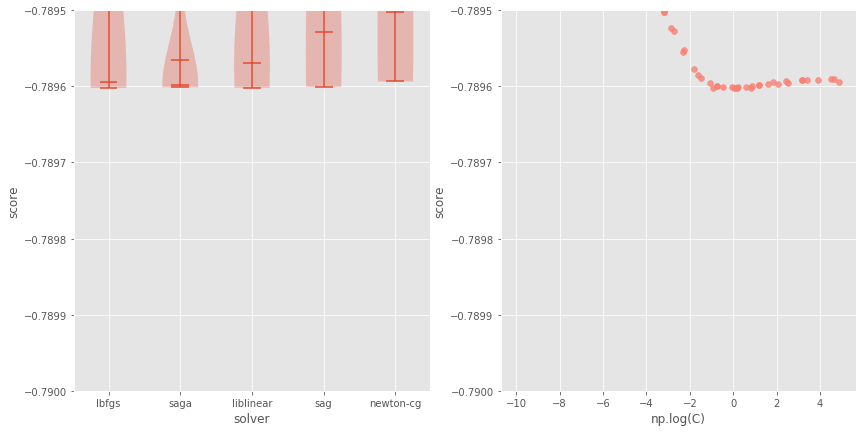

In [14]:
tuning.log.plot(score_interval=[-0.7900, -0.7895])

# TRAINING & SUBMISSION

In [ ]:
%%time

nflod = 5

model_param = {'probability': True}
model = SVC(**model_param)
cv = CV(model, nflod)

score = cv.fit(x=x_train,
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               use_proba=True, 
               verbose=True)

In [10]:
print(score)

0.7896149109718108


In [12]:
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')
submission['target'] = cv.predict(x=x_test, use_proba=True)
submission.to_csv(f'../tmp/submission/stacking_1_1_lr.csv')